In [1]:
import numpy as np
from numpy import diff
import pandas as pd
import pylab as pl
import matplotlib.pylab as plt
from datetime import datetime

from src.data import load_weight_sensor, load_radar, load_annotation
from src.utils import apply_envelope, apply_median_filter, get_start_end_times_of_boolean_sz

In [2]:
annotations = load_annotation.get_annotation('C:/Users/Jiajun/Desktop/download-project/data/processed/Annotation.csv')

defecation_complete_ids = load_annotation.get_complete_ids(
    annotation_filename='C:/Users/Jiajun/Desktop/download-project/data/processed/Annotation.csv',
    category='Defecation'
)

defecation_complete_ids

array([1802, 1806, 1830, 1831, 1839, 1854, 1862, 1863, 1870, 1875, 1881,
       1882, 1890, 1893, 1898, 1904, 1912, 1915, 1919, 1923, 1926, 1930,
       1933, 1937, 1940, 1941, 1943, 1944, 1947, 1955, 1992, 1994, 1995,
       1999, 2001, 2002, 2010, 2013, 2014, 2021, 2022, 2024, 2028, 2030,
       2034, 2041, 2044, 2050, 2051, 2055, 2057, 2061, 2062, 2065, 2066,
       2068, 2069, 2072, 2073,  922,  924,  989,  992,  993,  995,  926,
        928,  930,  934,  936,  938,  941,  942,  947,  948,  953,  954,
        958,  960,  964,  968,  970,  971,  976,  978,  979,  982,  984,
        985,  986,  987], dtype=int64)

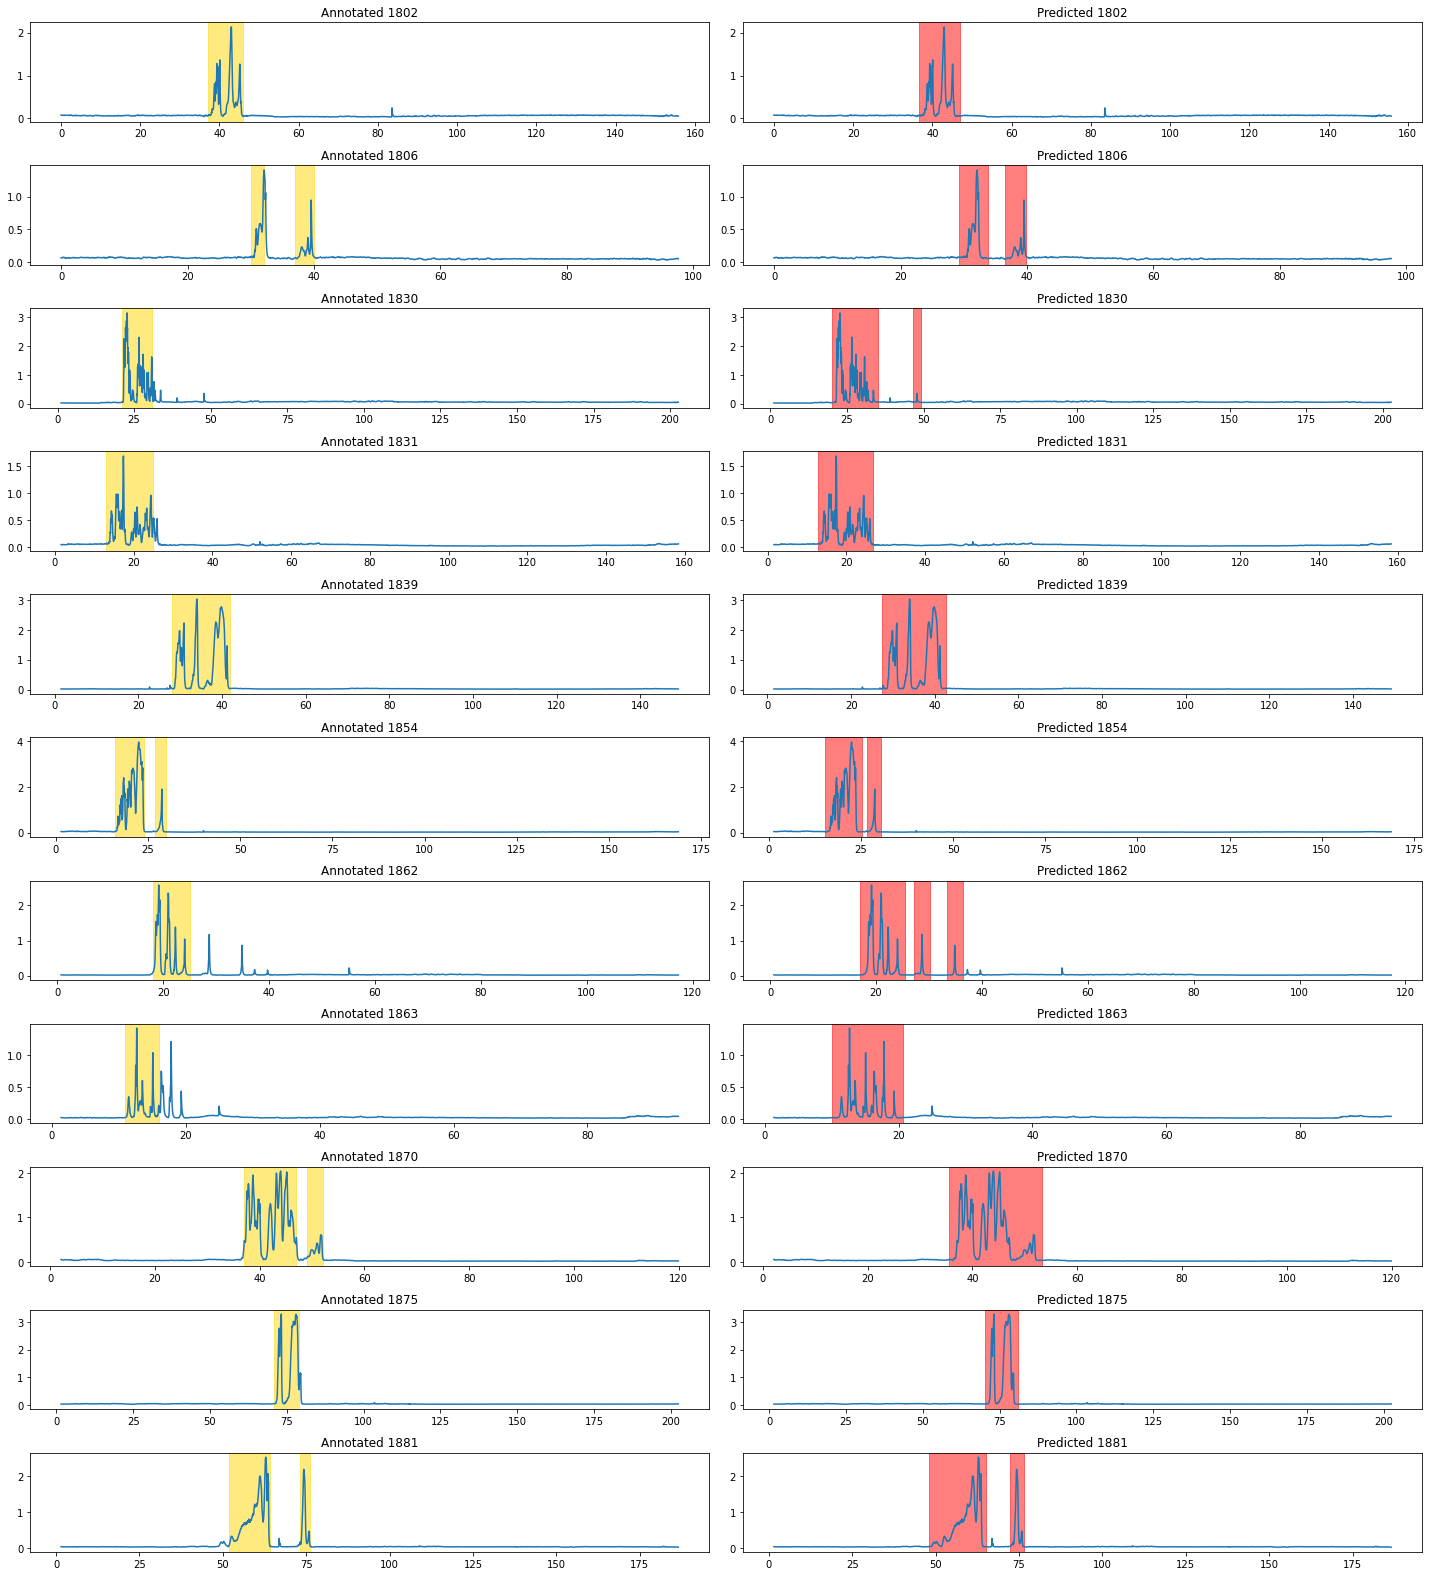

In [6]:
config = {
    'USE_IDS': [1802, 1806, 1830, 1831, 1839, 1854, 1862, 1863, 1870, 1875, 1881],
    'FILTER_WINDOW_SIZE': 5,
    'THRESHOLD': 0.15,
    'EXTENSION_TIME': 1.3
}


timestamp = datetime.now().strftime("%H-%M-%S")

Thresholding_Alg = ThresholdingAlgDefecation(config)
Thresholding_Alg.make_eval_plots(f'eval-defecation-manual-0205-{timestamp}.pdf')

In [5]:
class ThresholdingAlgDefecation:
    def __init__(self, config):
        self.use_ids = config['USE_IDS']
        self.filter_window_size = config['FILTER_WINDOW_SIZE']
        self.threshold = config['THRESHOLD']
        self.extension_time = config['EXTENSION_TIME']
    
    def get_values_above_threshold(self, sz):
        return sz > self.threshold
    
    def right_extend_boolean_true_values(self, sz):
        temp_sz = sz.copy()
        i = 1
        while i < len(temp_sz):
            if((temp_sz.values[i-1] == True) and (temp_sz.values[i] == False)):
                extension_end_time = temp_sz.index[i] + self.extension_time
                while (i < len(temp_sz)) and (temp_sz.index[i] < extension_end_time):
                    temp_sz.values[i] = True
                    i += 1
            i += 1
        return temp_sz
    
    def left_extend_boolean_true_values(self, sz):
        temp_sz = sz.copy()
        i = len(temp_sz) - 2
        while i >= 0:
            if((temp_sz.values[i] == False) and (temp_sz.values[i+1] == True)):
                extension_end_time = temp_sz.index[i] - self.extension_time
                while (i >= 0) and (temp_sz.index[i] > extension_end_time):
                    temp_sz.values[i] = True
                    i -= 1
            i -= 1
        return temp_sz        
    
    def get_annotated_times(self, use_i):
        times = []
        for time in annotations[use_i]:
            if time[-1] == 'Defecation':
                times.append([time[0], time[1]])
        return times
    
    def get_predicted_times(self, use_i):
        self.radar_sum_sz = load_radar.get_radar_sum_clean(use_i) / 1000
        radar_sum_env_sz = apply_envelope(self.radar_sum_sz)
        radar_sum_env_filt_sz = apply_median_filter(radar_sum_env_sz, self.filter_window_size)
        radar_sum_filt_sz = apply_median_filter(self.radar_sum_sz, self.filter_window_size)
        radar_vals_above_threshold = self.get_values_above_threshold(radar_sum_filt_sz)
        radar_vals_above_threshold = self.right_extend_boolean_true_values(radar_vals_above_threshold)
        radar_vals_above_threshold = self.left_extend_boolean_true_values(radar_vals_above_threshold)
        defecation_start_end_times = get_start_end_times_of_boolean_sz(radar_vals_above_threshold)
        return defecation_start_end_times
    
    def make_eval_plots(self, filename):
        nrow, ncol = len(self.use_ids), 2
        fig, axes = plt.subplots(nrow, ncol, figsize=(10*ncol, 2*nrow))
        for idx, use_i in enumerate(self.use_ids):
            predicted_times = self.get_predicted_times(use_i)
            annotated_times = self.get_annotated_times(use_i)
            axes[idx][0].plot(self.radar_sum_sz)
            axes[idx][1].plot(self.radar_sum_sz)
            for region in annotated_times:
                axes[idx][0].axvspan(region[0], region[1], color="gold", alpha=0.5)
                axes[idx][0].title.set_text(f'Annotated {use_i}')
            for region in predicted_times:
                axes[idx][1].axvspan(region[0], region[1], color="red", alpha=0.5)
                axes[idx][1].title.set_text(f'Predicted {use_i}')
        fig.tight_layout()
        plt.savefig(f'../reports/{filename}')